In [5]:
if __name__=="__main__":
	import sys
	sys.path.append('/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src')

In [6]:
from src.SMT_Analysis_BP.databases.trajectory_analysis_script import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.SMT_Analysis_BP.helpers.analysisFunctions.MSD_Utils import *
from src.SMT_Analysis_BP.helpers.ioModule.plotting_functions import *
from src.SMT_Analysis_BP.helpers.ioModule.import_functions import *
from src.SMT_Analysis_BP.helpers.analysisFunctions.Analysis_functions import *
from src.SMT_Analysis_BP.helpers.misc.diff_mw import *
from src.SMT_Analysis_BP.Random.scalebars import *
from src.SMT_Analysis_BP.helpers.analysisFunctions.MSD_Utils import MSD_Calculations
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')  
from src.SMT_Analysis_BP.Parameter_Store.global_params import *


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_5186/1367071063.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [7]:

loc_err_data= run_analysis(wd="/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/SMT_FAST_CAPTURE/Laci_LacO_Fixed_1%PFA_Photobleaching_20ms/No_Binning_65nm/20231002",
                          t_string="Photobleaching_LL_EZ_fixed")
                  
loc_err_data.read_parameters(minimum_percent_per_drop_in = .5, 
                    t_len_u = 1000, 
                    t_len_l=1,
                    cluster_t_len_l=10, 
                    minimum_tracks_per_drop = 3)

loc_err_data.get_blob_parameters(threshold=1e-4,
                        overlap=0,
                        detection_name='bp',
                        min_sigma=1/np.sqrt(2),
                        max_sigma=2.5/np.sqrt(2),
                        num_sigma=100,
                        median = False)

loc_err_data.get_fitting_parameters(kwargs={"mask_size":3,
                                    "plot_fit":False,
                                    "fitting_image":"Original",
                                    "radius_func":np.mean,#identity,
                                    "residual_func":residuals_gaus2d,
                                    "sigma_range":0.2,
                                    "centroid_range":0.2,
                                    "height_range":2})
loc_err_data.type_of_blob = "Scale"#"SCALE_SPACE_PLUS"#"Scale"#"SCALE_SPACE_PLUS"#"Scale"#"SCALE_SPACE_PLUS"#"SCALE_SPACE_PLUS"
loc_err_data.a_file_style = "new"
loc_err_data.my_name = "locerr"
loc_err_data.overwrite_cell_localizations = True
loc_err_data.run_flow(masked_movies=False) 


No gfp folder found in /Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/SMT_FAST_CAPTURE/Laci_LacO_Fixed_1%PFA_Photobleaching_20ms/No_Binning_65nm/20231002. Assuming no cell segmentation exists and running analysis without use of segmentation. 
 Note this mean the whole frame is a considered one cell
All files in the dataset:
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/SMT_FAST_CAPTURE/Laci_LacO_Fixed_1%PFA_Photobleaching_20ms/No_Binning_65nm/20231002/Analysis_new/Photobleaching_LL_EZ_fixed_10_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/SMT_FAST_CAPTURE/Laci_LacO_Fixed_1%PFA_Photobleaching_20ms/No_Binning_65nm/20231002/Analysis_new/Photobleaching_LL_EZ_fixed_11_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/SMT_FAST_CAPTURE/Laci_LacO_Fixed_1%PFA_Photobleaching_20ms/No_Binning_65nm/20231002/Analysis_new/Photobleaching_LL_EZ_fixed_12_seg.tif_spots.csv
/Users/baljyot/Documents/CODE/GitHub_t

/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/baljyot/opt/anaconda3/envs/SMT_env_BP/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



        ##############################################################################################################
        #You have initialized a Calculation class with the following parameters:
        #pixel_size: 0.065
        #frame_length: 0.02
        #pixel_unit: um
        #frame_unit: s
        
sigma = 21.701 +/- 0.348 nm


<Figure size 640x480 with 0 Axes>

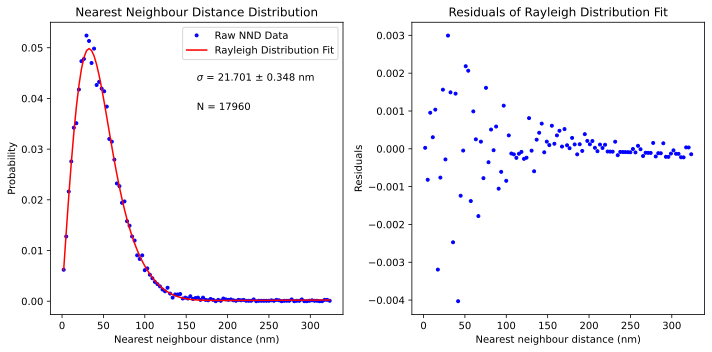

In [12]:
tau = 0.02
pixel_to_um = 0.065
msd_class_jd = MSD_Calculations([loc_err_data],pixel_to_um=pixel_to_um,frame_to_seconds=tau,min_track_length=2)
ens_disps = msd_class_jd.combined_store["ALL"].ensemble_displacement_r

#find the number of localizations in total across all movies
loc_number = 0
for i,j in loc_err_data.Movie.items():
    for k,l in j.Cells.items():
        loc_number += len(l.raw_tracks)

#fit the histogram with a rayleigh distribution
#get the bin centers and the probability at each bin by normalizing the histogram
pdf,bin_edges = np.histogram(ens_disps[tau],bins=int(np.sqrt(len(ens_disps[tau]))),weights=np.ones(len(ens_disps[tau]))/len(ens_disps[tau]))
#pdf,bin_edges = np.histogram(ens_disps[0.02],bins=int(np.sqrt(len(ens_disps[0.02]))),density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

#fit the pdf with the rayleigh distribution
popt,pcov = curve_fit(nnd_correction_rayleigh,bin_centers,pdf,maxfev=100000,p0=[0.015,0.1,0.1,0.1,0.1,0.1])
#print the fit parameters in pretty format, with the errors
print("sigma = {0:.3f} +/- {1:.3f} nm".format(1000*popt[0],1000*np.sqrt(pcov[0,0])))
#print("xc = {0:.3f} +/- {1:.3f} nm".format(1000*popt[1],1000*np.sqrt(pcov[1,1])))
#print("w = {0:.3f} +/- {1:.3f} nm".format(1000*popt[2],1000*np.sqrt(pcov[2,2])))

#plot the histogram and the fit
plt.clf()
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1,2)
ax = fig.add_subplot(gs[0,0])
ax.plot(bin_centers*1000,pdf,'b.',label="Raw NND Data")
ax.plot(bin_centers*1000,nnd_correction_rayleigh(bin_centers,*popt),'r-',label="Rayleigh Distribution Fit")
ax.text(0.5,0.8,"$\sigma$ = {0:.3f} $\pm$ {1:.3f} nm".format(1000*popt[0],1000*np.sqrt(pcov[0,0])),transform=ax.transAxes)
#display the total amount of localizations used 
ax.text(0.5,0.7,"N = {0:.0f}".format(loc_number),transform=ax.transAxes)
ax.legend()
ax.set_xlabel("Nearest neighbour distance (nm)")
ax.set_ylabel("Probability")
ax.set_title("Nearest Neighbour Distance Distribution")

#plot the residuals on ax1 to the left of the plot
ax1 = fig.add_subplot(gs[0,1])
ax1.plot(bin_centers*1000,pdf-nnd_correction_rayleigh(bin_centers,*popt),'b.',label="Residuals")
#plot the fit residuals
ax1.set_xlabel("Nearest neighbour distance (nm)")
ax1.set_ylabel("Residuals")
ax1.set_title("Residuals of Rayleigh Distribution Fit")
plt.tight_layout()
plt.show()


In [13]:
point_path = "/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/SMT_FAST_CAPTURE/Laci_LacO_Fixed_1%PFA_Photobleaching_20ms/No_Binning_65nm/20231002/Point_Results"
def theoretical_photons_loc_error(path,photon_conversion_factor,quantum_efficiency,dark_offset,pixel_size,psf_sigma,name):
    if isinstance(path,str):
        loc = glob.glob(path+'/*.csv')
        loc.sort()
    if isinstance(path,list):
        loc_global = []
        for i in path:
            loc = glob.glob(i+'/*.csv')
            loc.sort()
            loc_global.append(loc)
        loc = np.concatenate(loc_global)
    #from each of the .csv files load the data into a collective dataframe using concat
    loc_df = pd.DataFrame()
    for i in loc:
        loc_df = pd.concat([loc_df,pd.read_csv(i)])
    loc_df.reset_index(drop=True,inplace=True)
    #get the heights and the loc_error
    heights = loc_df['height'].values*loc_df['sig_x'].values*loc_df['sig_y'].values*2*np.pi
    print("Mean sig_x and sig_y: {:.2f} +/- {:.2f}".format(np.mean(loc_df['sig_x'].values),np.std(loc_df['sig_x'].values)))
    #convert the height values to # of photons using the photon conversion factor function in analysis functions
    photons_loc = photon_conversion_from_AUD(AUD=heights,
                                            photon_conversion_factor=photon_conversion_factor,
                                            quantum_efficiency=quantum_efficiency,
                                            dark_offset=0)
    background_photons = photon_conversion_from_AUD(AUD=abs((loc_df["Image_Background_Std"].values)),
                                                    photon_conversion_factor=photon_conversion_factor,
                                                    quantum_efficiency=quantum_efficiency,
                                                    dark_offset=0)
    print("Mean # of Photons: {:.2f} +/- {:.2f}".format(np.mean(photons_loc),np.std(photons_loc)))
    print("Mean # of Background Photons: {:.2f} +/- {:.2f}".format(np.mean(background_photons),np.std(background_photons)))
    #using the photons find the Thompson localization error
    loc_error = Thompson_localization_precision(pixel_size=pixel_size,psf_sigma=psf_sigma,num_photons=photons_loc,background_photons=0)

    #make a new figure 
    fig = plt.figure(figsize=(12,5))
    gs = fig.add_gridspec(1,2)
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    #plot the # of photons on the first axis
    ax1.hist(photons_loc,bins=int(np.sqrt(len(photons_loc))),weights=np.ones_like(photons_loc)/len(photons_loc),label = "# of Photons: {:.2f} +/- {:.2f} \n N = {}".format(np.mean(photons_loc),np.std(photons_loc),len(photons_loc)))
    ax1.set_xlabel("Peak Photons per Localization")
    ax1.set_ylabel("Frequency")
    # ax1.set_title("Peak Photons per Localization")
    #plot the loc_error on the second axis
    ax2.hist(loc_error,bins=int(np.sqrt(len(loc_error))),weights=np.ones_like(loc_error)/len(loc_error),label = "$\sigma$: {:.2f} +/- {:.2f} \n N = {}".format(np.mean(loc_error),np.std(loc_error),len(loc_error)))
    ax1.legend()
    ax2.legend()
    ax2.set_xlabel("Localization Error (nm)")
    # ax2.set_title("Localization Error")
    #supertitle
    fig.suptitle("Theoretical Localization Error using # of Photons \n Collected per Localization for: {}".format(name))
    plt.show()

Mean sig_x and sig_y: 2.20 +/- 0.30
Mean # of Photons: 488.93 +/- 197.28
Mean # of Background Photons: 1.73 +/- 0.01


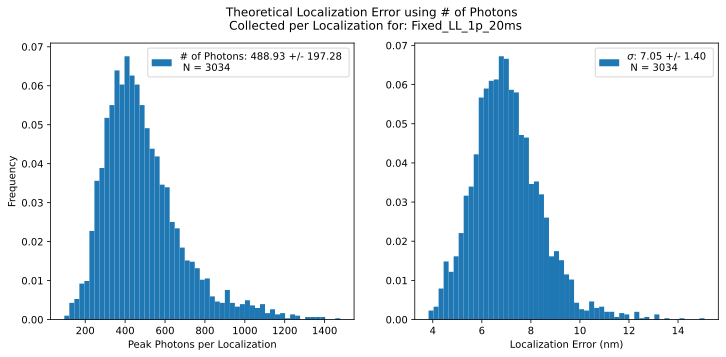

In [14]:
theoretical_photons_loc_error(point_path,
                              PHOTON_CONVERSION_FACTORS["olympus_sCMOS_new"],
                              QUANTUM_EFFICIENCY_561["olympus_sCMOS_new"],
                              dark_offset=100,
                              pixel_size=PIXELSIZES["olympus_pixel_size_1x1"],
                              psf_sigma=146,
                              name = "Fixed_LL_1p_20ms")

In [15]:
tau = 0.02
pixel_to_um = 0.065
msd_class_jd = MSD_Calculations([loc_err_data],pixel_to_um=pixel_to_um,frame_to_seconds=tau,min_track_length=7,max_track_length=7)


        ##############################################################################################################
        #You have initialized a Calculation class with the following parameters:
        #pixel_size: 0.065
        #frame_length: 0.02
        #pixel_unit: um
        #frame_unit: s
        


In [16]:
ens_msd=msd_class_jd.combined_store["ALL"].ensemble_MSD

In [23]:
#fit the first 4 points with a line in log-log space
def linear(x,m,b):
    return m*x+b
popt,pcov = curve_fit(linear,(list(ens_msd.keys())[0:5]),(list(ens_msd.values())[0:5]))
#print D in scientific notation
print("D = {:.2e} +/- {:.2e} um^2/s".format(popt[0],np.sqrt(pcov[0,0])))

D = 6.26e-03 +/- 1.31e-03 um^2/s
